# Save the crops notebook

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Imports
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

2024-03-29 10:54:25.456254: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 10:54:25.818349: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 10:54:25.818416: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 10:54:25.899157: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-29 10:54:26.050997: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-29 10:54:26.053688: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Get and clean the data
⚠️ Parts of the code is written to use in Google Colab. The data was originaly stored online in Google Drive.

### Let's first have a look at some pictures

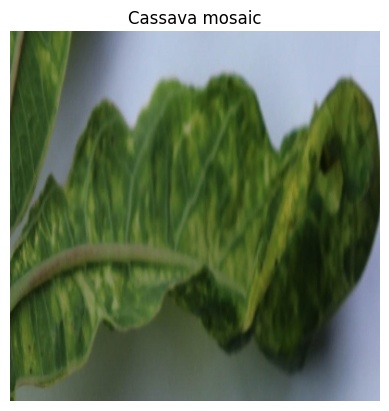

In [3]:
# ! unzip -n ~/code/MahautHDL/save_the_crops/raw_data/crop.zip -d ~/code/MahautHDL/save_the_crops/raw_data

data_link = os.environ.get("RAW_DATA_PATH")
crops = os.listdir(data_link)
plant_disease = np.random.randint(0, len(crops))
plant_disease_name = crops[plant_disease]

os.chdir(f'{data_link}/{plant_disease_name}')

link = os.listdir(f"{data_link}/{plant_disease_name}")
rand_pic_nr = np.random.randint(0, len(link))

img = plt.imread(link[rand_pic_nr])

plt.imshow(img)
plt.axis(False)
plt.title(plant_disease_name)
plt.show()

## Remove corrupted pictures
Parts of the datafile was corrupted, so we need to loop over the pictures to keep only the good ones.

In [4]:
from crops_package.data import check_for_errors_and_create_excel

# Depending on the platform, we use the kaggle or local link:
kaggle_link = "/kaggle/input/crop-pest-and-disease-detection"
local_link = os.environ.get("RAW_DATA_PATH")

check_for_errors_and_create_excel(local_link)

Tomato leaf blight finished.
Tomato leaf curl finished.
Tomato verticulium wilt finished.
Tomato healthy finished.
Tomato septoria leaf spot finished.
Tomato csv has been saved.
Cassava brown spot finished.
Cassava mosaic finished.
Cassava green mite finished.
Cassava healthy finished.
Cassava bacterial blight finished.
Cassava csv has been saved.
Cashew leaf miner finished.
Cashew gumosis finished.
Cashew red rust finished.
Cashew healthy finished.
Cashew anthracnose finished.
Cashew csv has been saved.
Maize leaf blight finished.
Maize fall armyworm finished.
Maize grasshoper finished.
Maize streak virus finished.
Maize leaf beetle finished.
Maize leaf spot finished.
Maize healthy finished.
Maize csv has been saved.
All csv's have been saved


## Models
Modify the crop you want to check below:

In [5]:
crop = "cashew"

### Split and preprocess per crop

In [6]:
from crops_package.data import preprocessor_df, split_data

# Load and preprocess the csv
## Kaggle
# data = pd.read_csv(f'/kaggle/input/csv-crops/{crop}.csv')
# data['filename'] = '/kaggle/input/crop-pest-and-disease-detection/' + data['filename']

## Local
data = pd.read_csv(f"../../data/{crop}.csv")
data['filename'] = f"{os.environ.get('RAW_DATA_PATH')}" + "/" + data['filename']
data['class'] = data['class'].astype(str)
data['class']

print("Dataframe loaded, starting with preprocessing")

train_df, val_df, test_df = split_data(data)
train_generator = preprocessor_df(train_df)
val_generator = preprocessor_df(val_df)

Dataframe loaded, starting with preprocessing
Found 4731 validated image filenames belonging to 5 classes.
Found 835 validated image filenames belonging to 5 classes.


### Start Callbacks and Tensorboard notebook

In [26]:
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

%load_ext tensorboard
from tensorboard import notebook

### Initialize, Fit and save model

In [59]:
from crops_package.model import initialize_model, fit_and_save_model

classes_in_crop = data['class'].unique().size
model = initialize_model(classes_in_crop)

globals()[f"history_{crop}"] = fit_and_save_model(model, train_generator, val_generator, crop, epochs = 100)
model.summary()

KeyboardInterrupt: 

### Check Tensorboard Notebook

In [28]:
%tensorboard --logdir ../callbacks
notebook.list() # View open TensorBoard instances

Reusing TensorBoard on port 6006 (pid 306955), started 0:00:50 ago. (Use '!kill 306955' to kill it.)

Known TensorBoard instances:
  - port 6006: logdir ../callbacks (started 0:00:50 ago; pid 306955)


### Check performance: plot the history

In [ ]:
from crops_package.model import plot_history
history = globals()[f"history_{crop}"]

plot_history(history, title=crop, axs=None, exp_name=crop)

### Load model if necessary

In [8]:
crop = crop    # change if you want to load another crop
model = tf.keras.models.load_model(f'../../models/saved_models/{crop}-model.keras', safe_mode=False)

## Testing our model

### Preprocessing and evaluating model and test data

In [51]:
from crops_package.data import preprocessor_test

test_generator = preprocessor_test(test_df)
res = model.evaluate((test_generator), verbose = 0)
res

Found 983 validated image filenames belonging to 5 classes.


[4.370996952056885, 0.28789418935775757]

## Predicting

### Get the class names (diseases / healty)

In [84]:
class_names = list(test_generator.class_indices.keys())
class_names

['Cashew anthracnose',
 'Cashew gumosis',
 'Cashew healthy',
 'Cashew leaf miner',
 'Cashew red rust']

### Predict an existing picture

#### Choose a picture via index

In [82]:
from crops_package.data import prepocessor_img_from_path

index = 102   # change index for different picture
filepath = list(test_df['filename'])[index]
filename = list(test_df['class'])[index]
img = plt.imread(filepath)
img_processed = prepocessor_img_from_path(filepath)
predictions = model.predict(img_processed)

1/1 [==============================] - 0s 44ms/step


In [ ]:
pred_outcome = class_names[np.argmax(predictions)].split()
pred_crop_name = pred_outcome[0]
pred_crop_disease = " ".join(pred_outcome[1:]).capitalize()

true_outcome = filename.split()
true_crop_name = true_outcome[0]
true_crop_disease = " ".join(true_outcome[1:]).capitalize()

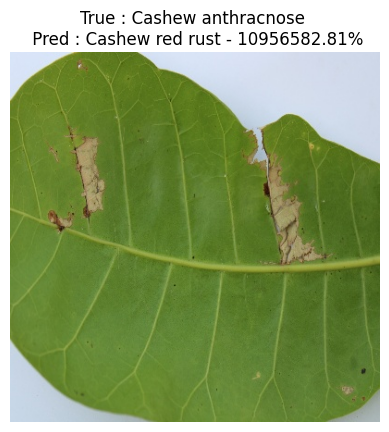

In [83]:
plt.imshow(img)
plt.axis(False)
plt.title(f"Crop: {true_crop_name} \n True : {true_crop_disease} \n Pred : {pred_crop_disease} - {np.max(predictions)* 100:.2f}%")
plt.show()

### Predict a new picture

In [85]:
from crops_package.data import prepocessor_img_from_path

path = '../../test_pictures/cashew.jpeg'     # upload a picture you want to test either from internet of locally
img_processed = prepocessor_img_from_path(path)

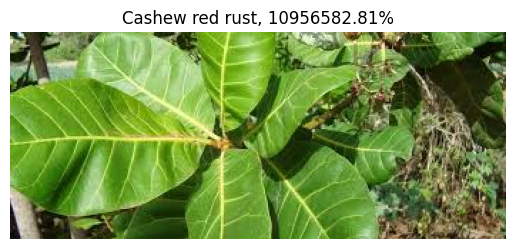

In [86]:
original_img = plt.imread(path)

pred_outcome_new = class_names[np.argmax(predictions)].split()
pred_crop_name = pred_outcome_new[0]
pred_crop_disease = " ".join(pred_outcome[1:]).capitalize()


plt.imshow(original_img)
plt.axis(False)
plt.title(f"Crop: {pred_crop_name} \n Pred : {pred_crop_disease} - {np.max(predictions)* 100:.2f}%")
plt.show()

## Upload the model to mlflow

In [ ]:
# Upload model to mlflow
import mlflow

from datetime import datetime

now = datetime.now()
dt_string = now.strftime("%d%m%y_%H%M%S")

mlflow.set_tracking_uri(os.environ.get("MLFLOW_TRACKING_URI"))
mlflow.set_experiment(experiment_name=f"save_the_crops_{dt_string}")
with mlflow.start_run():
    mlflow.tensorflow.log_model(model=model,
                                artifact_path="model",
                                registered_model_name=f"{crop}-model"
                               )

123